# NLP Final Project Scratch File

## Brainstorming

What we want to do: binary classification problem - fake news vs not fake news

Different options to consider/compare via Pipeline + GridSearchCV...

**Vectorizing Text Data**
- Count Vectorized matrix
    - max_df
    - min_df
    - lowercase
    - stop_words
    - max_features
- TF-IDF matrix
    - max_df
    - min_df
    - lowercase
    - stop_words
    - max_features

**Dimensionality Reduction**
- Topic distribution matrix
    - PCA, NMF, or LSA
    - Hyperparameters to tune:
        - n_components (# topics/features)
- Feature selection
    - Lasso
        - alpha
    - sklearn.feature_selection.SelectKBest
        - different scoring functions
        - different values for k (# features)

**ML Models**
- Supervised:
    - Logistic Regression
        - threshold value for predicting classes
        - logistic regression with l1 penalty can be used for feature selection
    - Linear SVC (better than regular SVC for large sample sizes)
        - penalty: {'l2', 'l1'} (default l2)
        - loss: {'hinge', 'squared_hinge'} (default squared_hinge)
        - C: regularization parameter (strength of regularization is inversely proportional to C); must be positive
    - Naive Bayes
        - Multinomial Naive Bayes
            - alpha (smoothing parameter between 0,1)
        - Complement Naive Bayes (*essentially MNB corrected for imbalanced datasets*)
            - alpha (smoothing parameter between 0,1)
    - Ridge Classifier
        - alpha
    - SGD Classifier
        - alpha
        - loss = 'hinge' (default) means linear SVM
        - loss = 'log' means logistic regression
        - penalty: {'l2', 'l1', 'elasticnet'} (l2 standard for linear SVM; l1 for lasso; elasticnet for l1 & l2
- Unsupervised (?):
    - K-Means Clustering (just for fun): # clusters


## Import Modules & Data

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import umap
# import other modules...

In [2]:
labels_df = pd.read_csv("./labels.csv")

In [3]:
articles_df = pd.read_csv('./articles_df.csv', index_col = 0)
articles_df.head()

,news_source,pub_date,title,text
0,Talking Points Memo,2018-07-14,Trump Admin Will Start Reunifying Older Kids W...,The Trump administration says it expects to be...
1,Talking Points Memo,2018-07-14,Louie Gohmert Is Our Duke Of The Week,As our Allegra Kirkland and Tierney Sneed have...
2,Talking Points Memo,2018-07-14,Top State Election Officials Gather Amid Secur...,Trump has never condemned Russia over its medd...
3,Talking Points Memo,2018-07-14,Indictment Russia Hack Targeted Clinton Emails...,"In a July 27, 2016, speech, then-candidate Don..."
4,Talking Points Memo,2018-07-14,Nielsen No Indication Russia Targeting 2018 El...,PHILADELPHIA (AP) The U.S. homeland security ...


In [4]:
articles_df['text'][13700]

'Barack Obama has come out of relative political hiding to endorse an array of Democratic candidates in the midterm elections.\n\nThe former president released the list of 81 candidates on Twitter Wednesday  in elections as large in scale as Governor, as well as smaller races such as State Senate.\n\nIm confident that, together, theyll strengthen this country we love by restoring opportunity, repairing our alliances and standing in the world, and upholding our fundamental commitment to justice, fairness, responsibility, and the rule of law, Obama said of his picks. But first, they need our votes.\n\nThis is just the first wave of endorsements from 44 for these midterms, but it leaves out a few pretty large names, including New Yorks rising star, socialist Alexandria Ocasio-Cortez.\n\nOcasio-Cortez gained quick fame after defeating Democratic establishment candidate Joe Crowley (D-NY) in the race for New Yorks 14th congressional district. She campaigned with Sen. Bernie Sanders (I-VT) f

In [5]:
len(articles_df)

697695

In [6]:
articles_df['text'][20554]

nan

In [7]:
no_text = []
for i in range(len(articles_df)):
    if type(articles_df['text'][i]) != str:
        no_text.append(i)
len(no_text)

828

In [8]:
# get rid of any blank articles
articles_df = articles_df.drop(no_text).reset_index(drop = True)
len(articles_df)

696867

In [9]:
# check for any strings with no word characters
no_words = []
for i in range(len(articles_df)):
    if re.match('^[\W_]+$', articles_df['text'][i]):
        no_words.append(i)
len(no_words)

0

In [10]:
articles_df['news_source'].unique()

array(['Talking Points Memo', 'The Inquisitr', 'Addicting Info',
       'News Biscuit', 'Veterans Today', 'The Daily Blog',
       'Drudge Report', 'Politicus USA', 'ABC News', 'ThinkProgress',
       'MotherJones', 'Daily Mail', 'Salon', 'Hit and Run', 'The Duran',
       'Conservative Tribune', 'Mint Press News', 'TheBlaze',
       'The Huffington Post', 'Washington Post',
       'Media Matters for America', 'The New York Times', 'Reuters',
       'iPolitics', 'Waking Times', 'BBC', 'Bearing Arms',
       'Conservative Home', 'Intellihub', 'Breitbart', 'Business Insider',
       'The Guardian', 'HumansAreFree', 'News Busters', 'The Intercept',
       'Infowars', 'Yahoo News', 'oann', 'NPR',
       'The Conservative Tree House', 'RT', 'Sputnik', 'CNS News',
       'The Verge', 'CBS News', 'Dick Morris Blog', 'The Daily Caller',
       'Daily Kos', 'CNN', 'The Atlantic', 'The Spoof', 'Buzzfeed',
       'True Pundit', 'Hot Air', 'Vox', 'Fox News', 'Crooks and Liars',
       'Live Action

## Clean Data

In [11]:
# Things we might want to remove from the text:
# - political rep. tags, e.g. (D-NY) for Democrat, New York
# - email addresses asking for tips or comments
# - internet domains (?)
# - do we want to keep punctuation? (for instance, maybe "!" is used more often in fake news articles)
#
# Other considerations:
# - remove stopwords?
# - lemmatize words?

# define a function to clean text data

# to convert nltk_pos tags to wordnet-compatible PoS tags
def convert_pos_wordnet(tag):
    tag_abbr = tag[0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
                
    if tag_abbr in tag_dict:
        return tag_dict[tag_abbr]

# to convert contractions picked up by word_tokenize() into full words
contractions = {
    "n't": 'not',
    "'ve": 'have',
    "'s": 'is', # note that this will include possessive nouns
    'gonna': 'going to',
    'gotta': 'got to',
    "'d": 'would',
    "'ll": 'will',
    "'re": 'are',
    "'m": 'am',
    'wanna': 'want to'
}

# Set list of "valid" tags such that when normalizing text, all words tagged with PoS = coordinating conjunction,
# cardinal digit, determiner, existential there, preposition/subordinating conjunction, list marker, predeterminer,
# possessive ending, personal pronoun, possessive pronoun, to, or interjection are dropped.
valid_tags_abbr = 'FJMNRVW'

def clean_text(str_list, lemmatize = True):
    clean_list = []
    
    for text in str_list:
        # to drop any internet domains, email addresses, or political rep. "tags"
        text = re.sub(r'\w+@?\w+(\.\w+)+|\([DRI]-[A-Z]{2}\)', '', text)
        words = word_tokenize(text)
        clean_words = []
        
        for word in words:
            PoS_tag = nltk.pos_tag([word])[0][1]
            word = re.sub(r'[_-]', '', word)
            
            # to change contractions to full word form
            if word in contractions:
                word = contractions[word]
            
            # drop words with fewer than 2 characters; drop any punctuation "words"; drop words not in
            # approved set of PoS tags (defined above)
            if (len(word) > 1) and (re.match(r'^\w+$', word)) and (PoS_tag[0].upper() in valid_tags_abbr):

                if lemmatize:
                    lemmatizer = WordNetLemmatizer()

                    if PoS_tag[0].upper() in 'JNVR':
                        word = lemmatizer.lemmatize(word, convert_pos_wordnet(PoS_tag))
                    else:
                        word = lemmatizer.lemmatize(word)
            
                clean_words.append(word)
        clean_text = ' '.join(clean_words)
        clean_list.append(clean_text)
    
    return clean_list

In [12]:
# Test on sample of 50,000 articles bc testing on all ~700K takes too long to run
articles_df_small = articles_df.sample(n = 50000).reset_index(drop = True)
articles_df_small['clean_txt'] = clean_text(articles_df_small['text'])

In [13]:
articles_df_small['clean_txt'][0]

'PJ Media encourages read update PRIVACY POLICY COOKIE POLICY'

## Split - Train & Test

In [14]:
articles_train, articles_test = train_test_split(articles_df_small)

# Features for Training Classifier

## Count Vectorizer

In [15]:
vectorizer_count = CountVectorizer(stop_words = 'english', ngram_range = (1,2), max_df = 0.90, min_df = 2)
X_train_count = vectorizer_count.fit_transform(articles_train['clean_txt'])
X_test_count = vectorizer_count.transform(articles_test['clean_txt'])

## TF-IDF Vectorizer

In [16]:
vectorizer_tfidf = TfidfVectorizer(stop_words = 'english', ngram_range = (1,2), max_df = 0.90, min_df = 2)
X_train_TFIDF = vectorizer_tfidf.fit_transform(articles_train['clean_txt'])
X_test_TFIDF = vectorizer_tfidf.transform(articles_test['clean_txt'])

## NMF Topic Modeling

In [17]:
# set number of topics
K = 10

# NMF on TF matrix
#
# get model for analysis of topic coherence
nmf_count = NMF(n_components = K).fit(X_train_count)
#
# fit & transform model
nmf = NMF(n_components = K)
W_train_count = nmf.fit_transform(X_train_count)
W_test_count = nmf.transform(X_test_count)

# NMF on TF-IDF matrix
#
# get model for analysis of topic coherence
nmf_tfidf = NMF(n_components = K).fit(X_train_TFIDF)
#
# fit & transform model
nmf = NMF(n_components = K)
W_train_tfidf = nmf.fit_transform(X_train_TFIDF)
W_test_tfidf = nmf.transform(X_test_TFIDF)

In [18]:
# define function to retrieve top n words from k topics
def top_words(model, features, n):
    for i, topic in enumerate(model.components_):
        message = 'Topic ' + str(i+1) + ': '
        topic_words = []
        for j in topic.argsort()[-n:][::-1]:
            topic_words.append(features[j])
        print(message + str(', '.join(topic_words)))
        
# define intrinsic topic coherence scorer
def topic_coherence(topic, termDict, termMatrix):
    coherence = 0
    for word in topic:
        j = termDict[word] # for word v_i
        other_words = [other_w for other_w in topic if other_w != word] # list of all other words in topic
        doc_i = 0 #doc_i = # docs containing word v_i
        doc_ij = 0 #doc_ij = # docs containing words v_i and v_j
        
        for i in range(termMatrix.shape[0]): # calculate number of documents with word v_i
            if termMatrix[i,j] > 0:
                doc_i += 1
                
                for other_w in other_words: # iterate over all other words in topic
                    index = termDict[other_w]
                    if termMatrix[i,index] > 0: # catches docs with word v_i that also contain word v_j
                        doc_ij += 1

                    score = np.log((doc_ij + 1)/doc_i) # calculate score for each pairwise comparison of v_i, v_j
                    coherence += score # sum scores for each pairwise comparison to get topic coherence score
    
    return np.round(coherence, 2)

In [19]:
# set number of words per topic
n = 8

# print topics and topic coherence scores for NMF TF-IDF model
features = vectorizer_tfidf.get_feature_names()
print('NMF Tf-idf')
top_words(nmf_tfidf, features, n)
print('\nTopic Coherence Scores:')

sum_coh = 0
for i, topic in enumerate(nmf_tfidf.components_):
    msg = 'Topic ' + str(i+1) + ': '
    topic_words = []
    for j in topic.argsort()[-n:][::-1]:
        topic_words.append(features[j])
    msg += str(topic_coherence(topic_words, vectorizer_tfidf.vocabulary_, X_train_TFIDF))
    sum_coh += topic_coherence(topic_words, vectorizer_tfidf.vocabulary_, X_train_TFIDF)
    print(msg)

avg_coh = sum_coh/K
print('Average topic coherence: ' + str(avg_coh))

# print topics and topic coherence scores for NMF TF model
features = vectorizer_count.get_feature_names()
print('\n')
print('NMF TF')
top_words(nmf_count, features, n)
print('\nTopic Coherence Scores:')

sum_coh = 0
for i, topic in enumerate(nmf_count.components_):
    msg = 'Topic ' + str(i+1) + ': '
    topic_words = []
    for j in topic.argsort()[-n:][::-1]:
        topic_words.append(features[j])
    msg += str(topic_coherence(topic_words, vectorizer_count.vocabulary_, X_train_count))
    sum_coh += topic_coherence(topic_words, vectorizer_count.vocabulary_, X_train_count)
    print(msg)

avg_coh = sum_coh/K
print('Average topic coherence: ' + str(avg_coh))

NMF Tf-idf
Topic 1: say, people, police, year, child, make, woman, just
Topic 2: nginx, forbidden nginx, forbidden, oday, law, wine, ban, halal
Topic 3: http, http http, post http, site http, publish site, originally publish, http originally, originally
Topic 4: trump, president, white house, white, house, mueller, cohen, say
Topic 5: north, deal, iran, eu, china, say, trade, korea
Topic 6: der, die, und, den, zu, von, mit, auf
Topic 7: game, league, season, player, club, team, manchester, win
Topic 8: tap add, http tap, journal home, add western, home screen, western journal, tap, screen
Topic 9: vote, democrats, senate, republican, election, court, republicans, democratic
Topic 10: saudi, khashoggi, arabia, saudi arabia, prince, consulate, crown prince, jamal

Topic Coherence Scores:
Topic 1: 759461.59
Topic 2: -85520.72
Topic 3: 140580.25
Topic 4: 404489.19
Topic 5: -44631.74
Topic 6: 9934.54
Topic 7: 102883.6
Topic 8: 764.01
Topic 9: 218518.43
Topic 10: 41193.26
Average topic coher

## PoS Tag Counts

In [ ]:
nltk.help.upenn_tagset()

In [20]:
tagList = ['$','#','\'\'',',','(',')','--','.',':','CC','CD','DT','EX','FW','IN','JJ','JJR','JJS','LS','MD','NN','NNP','NNPS','NNS','PDT','POS','PRP','PRP$','RB','RBR','RBS','RP','SYM','TO','UH','VB','VBD','VBG','VBN','VBP','VBZ','WDT','WP','WP$','WRB','``']

# create PoS tag count matrix
def pos_transf(corpus):
    dict_list = []
    for text in corpus:
        d = {x:0 for x in tagList}
        words = word_tokenize(text)

        for word in words:
            if word in contractions:
                word = contractions[word]

            tag = nltk.pos_tag([word])
            d[tag[0][1]] += 1
        dict_list.append(d)
    return pd.DataFrame(dict_list)        

In [21]:
pos_train = pos_transf(articles_train['text'])
pos_test = pos_transf(articles_test['text'])

In [23]:
pos_train.head()

,$,#,'',",",(,),--,.,:,CC,...,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,19,1,1,0,16,1,10,...,12,8,12,1,7,0,4,0,0,0
2,0,0,0,15,1,1,0,12,2,11,...,11,2,14,0,7,2,1,0,0,0
3,0,0,0,69,8,8,0,52,3,51,...,6,26,34,8,17,7,10,1,5,0
4,0,0,0,33,3,3,0,26,6,22,...,4,18,16,5,21,2,3,0,5,0


## Sentiment Analysis

In [24]:
# compute average sentiment score for each text using Positiv and Negativ lists from hw 4 (?)

## Create X matrix

X should contain the following features: average sentiment score; PoS tag counts; k topics; possibly features from TF-IDF matrix and/or TF matrix; news source.

In [25]:
# X_full_train = ...
#
# only doing nmf-tfidf matrix + pos tags matrix here
X_full_train = np.concatenate((W_train_tfidf, pos_train.to_numpy()), axis = 1)

# X_full_test = ...
#
# only doing nmf-tfidf matrix + pos tags matrix here
X_full_test = np.concatenate((W_test_tfidf, pos_test.to_numpy()), axis = 1)

# Train ML Models

## Logistic Regression Classifier
Train a logistic regression classifier on the X matrix.

In [26]:
# need to decide on what to use for response variable based on options in labels.csv file

## K-Means Clustering
Cluster documents based on the X matrix.

In [39]:
cl = 5 # set number of clusters

In [40]:
# Cluster on full X train matrix (for now just using nmf-tfidf matrix + pos tags matrix)
kmeans = MiniBatchKMeans(n_clusters = cl).fit(X_full_train)
labels = kmeans.labels_

# Evaluate Trained Models

## Logistic Regression Classifier

## K-Means

In [41]:
# Cluster on full X test matrix (for now just using nmf-tfidf matrix + pos tags matrix)
predictions = kmeans.predict(X_full_test)

# Data Visualization

## Topic Distribution for Sample Documents
Bar plots of topic weights for a couple of documents.

## Dimensionality Reduction

### PCA
Number of components = 2 or 3. Plot high-dimensional X data matrix in 2 or 3 dimensions using principal components. Color by cluster label or logistic regression label.

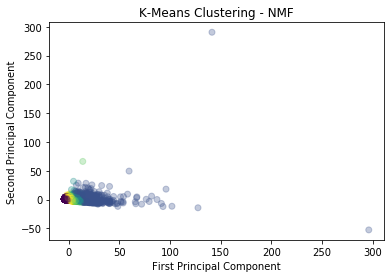

In [42]:
df = pd.DataFrame(labels, columns = ['label'])

# standardize feature vectors before performing dimensionality reduction
scaler = StandardScaler()
X_full_train_std = scaler.fit_transform(X_full_train)

# perform dimensionality reduction via PCA
pca = PCA(n_components = 2)
pca_result = pca.fit_transform(X_full_train_std)

source = articles_train['news_source']
df['news_source'] = source
df['pca_one'] = pca_result[:,0]
df['pca_two'] = pca_result[:,1]

# plot figure
plt.scatter(df['pca_one'], df['pca_two'], c = labels, alpha = 0.3)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('K-Means Clustering - NMF')
plt.show()

In [43]:
# total counts of articles by news source
art_counts = pd.DataFrame(df['news_source'].value_counts()).reset_index()

# counts of articles by news source per cluster
clusters = df['label'].unique()
for el in clusters:
    clust_cats = df[df['label'] == el]['news_source'].value_counts()
    print('Cluster ' + str(el+1) + ':')
    print(clust_cats)
    print('\n')
    
# % of articles by news source per cluster
for el in clusters:
    clust_percs = []
    sources = []
    art_counts_byclust = pd.DataFrame(df[df['label'] == el]['news_source'].value_counts()).reset_index()
    for i in range(len(art_counts_byclust)):
        perc = art_counts_byclust['news_source'][i]/art_counts[art_counts['index']==art_counts_byclust['index'][i]].reset_index(drop = True)['news_source'][0]
        clust_percs.append(np.round(100*perc, 2))
        sources.append(art_counts_byclust['index'][i])
    print('Cluster ' + str(el+1) + ':')
    for i in range(len(clust_percs)):
        print(sources[i] + '\t' + str(clust_percs[i]) + '%')
    print('\n')

Cluster 1:
The Sun                 952
theRussophileorg        731
Sputnik                 711
New York Post           573
The Independent         487
                       ... 
AMERICAblog News          1
Democracy 21              1
FT Westminster Blog       1
Counter Current News      1
Freedom Daily             1
Name: news_source, Length: 188, dtype: int64


Cluster 4:
The Sun             128
Sputnik             104
New York Post        92
theRussophileorg     79
The Independent      59
                   ... 
The Duran             1
Observer              1
Channel 4 UK          1
Politics UK           1
Daily Signal          1
Name: news_source, Length: 154, dtype: int64


Cluster 5:
The Sun                     563
theRussophileorg            378
Sputnik                     371
New York Post               337
The Independent             262
                           ... 
Feministing Blog              1
The Michelle Malkin Blog      1
Forward Progessives           1
Wings Over Sc

Cluster 5:
The Sun	32.9%
theRussophileorg	30.41%
Sputnik	29.85%
New York Post	31.88%
The Independent	31.01%
BBC	34.46%
Evening Standard	30.01%
Drudge Report	27.75%
The Telegraph	29.19%
The Guardian UK	28.41%
oann	34.46%
Instapundit	28.98%
True Pundit	32.68%
The Daily Mirror	28.71%
The Daily Caller	28.75%
sott.net	30.98%
Newsweek	30.21%
Mail	32.75%
Birmingham Mail	33.13%
CNN	31.39%
MSNBC	34.17%
The Manchester Evening News	29.32%
Daily Beast	30.07%
The Daily Record	30.11%
The New York Times	31.64%
Tass	35.87%
Real Clear Politics	32.79%
USA Today	31.1%
NPR	33.33%
BBC UK	30.67%
Talking Points Memo	31.72%
Spiegel	38.5%
Fortune	25.81%
The Denver Post	34.85%
Mercury News	34.16%
National Review	30.94%
Western Journal	33.83%
RedState	37.78%
CBS News	29.06%
The Gateway Pundit	29.91%
The Huffington Post UK	30.73%
ThinkProgress	31.58%
The Verge	29.28%
CNS News	30.05%
Alternet	34.05%
Bipartisan Report	33.7%
The Huffington Post	26.43%
TheBlaze	26.39%
Natural News	31.95%
iPolitics	29.44%
Raw Story	32

### t-SNE

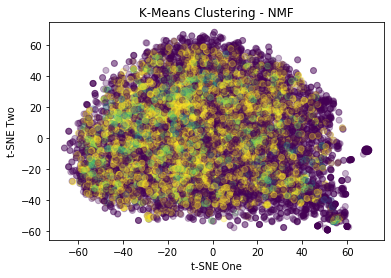

In [44]:
# select first 10K entries in X train matrix
X_train_sample = X_full_train[:10000]

# conduct t-SNE dimensionality reduction
tsne = TSNE(n_components = 2, metric = 'cosine')
tsne_results = tsne.fit_transform(X_train_sample)
tsne_df = pd.DataFrame()
tsne_df['tsne_one'] = tsne_results[:,0]
tsne_df['tsne_two'] = tsne_results[:,1]

# plot figure
plt.scatter(tsne_df['tsne_one'], tsne_df['tsne_two'], c = labels[:10000], alpha = 0.3)
plt.xlabel('t-SNE One')
plt.ylabel('t-SNE Two')
plt.title('K-Means Clustering - NMF')
plt.show()

### UMAP

In [45]:
# to avoid unnecessary warning messages...
# taken from this thread: https://github.com/lmcinnes/umap/issues/252
import warnings
warnings.filterwarnings('ignore')

fit = umap.UMAP()
u = fit.fit_transform(X_full_train)

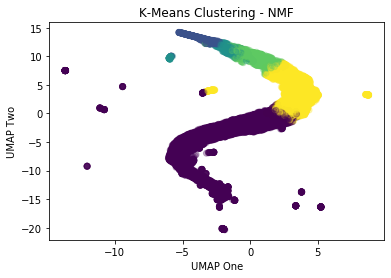

In [46]:
# plot figure
plt.scatter(u[:,0], u[:,1], c = labels, alpha = 0.3)
plt.xlabel('UMAP One')
plt.ylabel('UMAP Two')
plt.title('K-Means Clustering - NMF')
plt.show()

# Feature Selection